In [1]:
# HIDE CODE


import re
import os
import sys
import collections
import numpy as np
import pandas as pd
import nibabel as nib
from pathlib import Path
from os.path import join as pjoin
from scipy import stats as sp_stats
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')


# GitHub
git_path = pjoin(os.environ['HOME'], 'Dropbox/git/Ca-fMRI/')
sys.path.insert(0, git_path)
from simulation.simulation import *
from utils.plotting import *
from utils.processing import *
from model.configuration import Config

In [2]:
def plot_corrs(pearson, spearman, thresholds=None, figsize=None):
    if thresholds is None:
        thresholds = set(pearson.keys()).intersection(spearman.keys())
        
    if figsize is None:
        figsize = (13.5, 5.5 - np.ceil(len(thresholds) / 6))

    sns.set_style('white')
    fig, axes = plt.subplots(2, len(thresholds), figsize=figsize)

    for i, th in enumerate(sorted(thresholds)):
        sns.heatmap(
            pearson[th],
            cmap='nipy_spectral',
            vmin=th,
            vmax=1.,
            cbar_kws={'aspect': 5*len(thresholds), 'shrink': 0.9},
            ax=axes[0, i]
        )
        axes[0, i].set_aspect('equal')
        axes[0, i].set_xticks([])
        axes[0, i].set_yticks([])
        msg = 'top {:.1f}{:s} of corrs'
        msg = msg.format((pearson[th]>0).sum() / len(pearson[th]) ** 2 * 100, '%')
        axes[0, i].set_title(msg, fontsize=13)
        
        sns.heatmap(
            spearman[th],
            cmap='nipy_spectral',
            vmin=th,
            vmax=1.,
            cbar_kws={'aspect': 5*len(thresholds), 'shrink': 0.9},
            ax=axes[1, i]
        )
        axes[1, i].set_aspect('equal')
        axes[1, i].set_xticks([])
        axes[1, i].set_yticks([])
        msg = 'threshold = {:.2f}\n\ntop {:.1f}{:s} of corrs'
        msg = msg.format(th, (spearman[th]>0).sum() / len(spearman[th]) ** 2 * 100, '%')
        axes[1, i].set_title(msg, fontsize=13)

        if i == 0:
            axes[0, i].set_ylabel('pearson', fontsize=15)
            axes[1, i].set_ylabel('spearman', fontsize=15)

    msg = 'Correlation mats using different thresholds.  1st row: pearson, 2nd row: spearman'
    fig.suptitle(msg, y=1.03, fontsize=17)
    fig.tight_layout()
    plt.show()
    
    return
    


def filter_islands(partition, atlas, node_labels, min_com_size: int = 3):
    coms_ctr = collections.Counter(partition.values())
    
    good_com_idxs = zip(*filter(lambda x: x[1] > min_com_size, coms_ctr.most_common()))
    good_com_idxs = sorted(tuple(good_com_idxs)[0])
    bad_com_idxs = [item for item in set(partition.values()) if item not in good_com_idxs]

    comm_dict = collections.defaultdict(list)
    for k, v in partition.items():
        comm_dict[v].append(k)
    comm_dict = dict(sorted(comm_dict.items()))

    comm_mat = np.ones(atlas.shape) * -1
    for node, com_idx in partition.items():
        region_id = node_labels[node]
        if com_idx in good_com_idxs:
            comm_mat[atlas == region_id] = good_com_idxs.index(com_idx)
        else:
            comm_mat[atlas == region_id] = np.nan
    
    output = {
        'good_com_idxs': good_com_idxs,
        'bad_com_idxs': bad_com_idxs,
        'comm_dict': comm_dict,
        'comm_mat': comm_mat,
    }
    return output


def plot_louvain_communities(
    pearson: dict,
    spearman: dict,
    atlas: np.ndarray,
    modularities: dict,
    selected_idxs: list,
    pearson_th: float = 0.8,
    spearman_th: float = 0.7,
    figsize=(12, 4.5),
    colorbar=False, ):

    x0, y0 = tuple(zip(*modularities.items()))
    best_idx = np.argmax(y0)
    best_res = x0[best_idx]
    
    sns.set_style('white')
    plot_idxs = sorted(selected_idxs + [best_idx])
    fig, axes = plt.subplots(2, len(plot_idxs), figsize=figsize)

    for ii, idx in enumerate(plot_idxs):
        # pearson
        g = nx.from_numpy_matrix(pearson[pearson_th])
        coms = cdlib_algorithms.louvain(
            g_original=g,
            weight='weight',
            resolution=x0[idx],
            randomize=False,
        )
        partition = convert('community', 'partition', community=coms.communities)
        output = filter_islands(partition, atlas, node_labels, min_com_size=3)
        q = nx_comm.modularity(g, communities=coms.communities)

        im = axes[0, ii].imshow(output['comm_mat'], cmap='Spectral_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[0, ii], shrink=0.7)
        msg = 'Q = {:.3f},  # com = {:d}'
        msg = msg.format(q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))
        axes[0, ii].set_title(msg, y=1.03)
        
        # spearman
        g = nx.from_numpy_matrix(spearman[spearman_th])
        coms = cdlib_algorithms.louvain(
            g_original=g,
            weight='weight',
            resolution=x0[idx],
            randomize=False,
        )
        partition = convert('community', 'partition', community=coms.communities)
        output = filter_islands(partition, atlas, node_labels, min_com_size=3)
        q = nx_comm.modularity(g, communities=coms.communities)
    
        im = axes[1, ii].imshow(output['comm_mat'], cmap='RdYlBu_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[1, ii], shrink=0.7)
        msg = 'res = {:.3f}\n\nQ = {:.3f},  # com = {:d}'
        msg = msg.format(x0[idx], q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))
        axes[1, ii].set_title(msg, y=1.03)
        

        if ii == 0:
            axes[0, ii].set_ylabel('pearson\n(th = {:.2f})\n'.format(pearson_th), fontsize=12)
            axes[1, ii].set_ylabel('spearman\n(th = {:.2f})\n'.format(spearman_th), fontsize=12)
            
        for j in range(2):
            axes[j, ii].set_xticks([])
            axes[j, ii].set_yticks([])

    fig.tight_layout()
    plt.show()
    
    return

### Load data

In [3]:
config = Config()

load = load_organized_data(
    folder='atlas-32_unfiltered_unnormalized',#'filtered_low-0.001_high-4.000_ord-2_normalized',
    config=config,
    subject=6,
    session=1,
    run=1,
)
load.keys()

dict_keys(['ca', 'atlas', 'ref', 'mask', 'atlas_kmeans', 'kmeans_centers', 'file_name'])

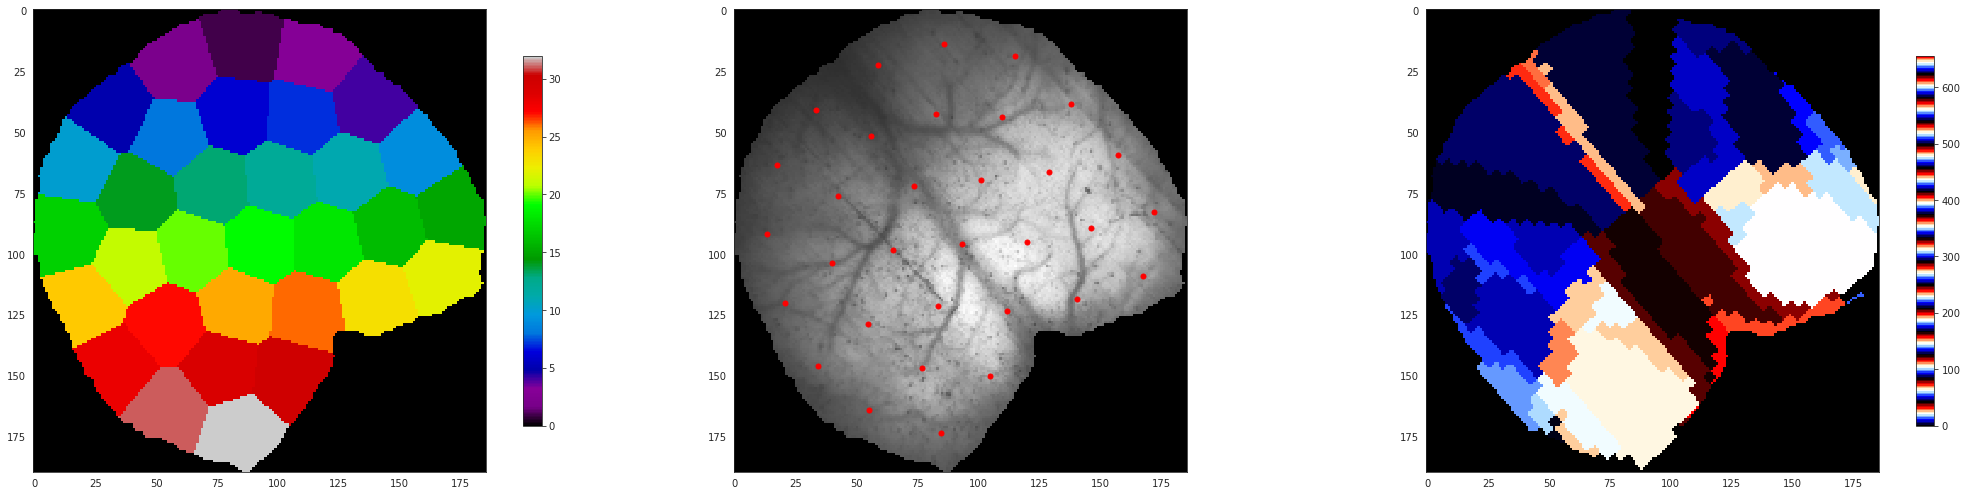

In [4]:
plt.figure(figsize=(30, 7))
plt.subplot(131)
plt.imshow(load['atlas_kmeans'], cmap='nipy_spectral', interpolation='none')
plt.colorbar(shrink=0.8)

plt.subplot(132)
plt.imshow(load['ref'], cmap='Greys_r', interpolation='none')
for j, i in load['kmeans_centers']: 
    plt.plot(i, j, marker='o', color='r', markersize=5)
    
plt.subplot(133)
plt.imshow(load['atlas'], cmap='flag_r', interpolation='none')
plt.colorbar(shrink=0.8)

plt.tight_layout()
# plt.savefig('kmeans_atlas.png', dpi=300)
plt.show()

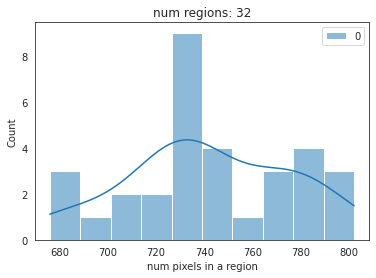

In [5]:
num_regions = max(np.unique(load['atlas_kmeans']))
num_pixs_per_roi = {k: len(np.where(load['atlas_kmeans'] == k)[0]) for k in range(1, num_regions+1)}

_ = sns.histplot(num_pixs_per_roi.values(), kde=True, bins=10)
plt.title('num regions: {:d}'.format(num_regions))
plt.xlabel('num pixels in a region')
plt.show()

In [6]:
x = np.zeros(load['atlas_kmeans'].shape + (list(load['ca'].values())[0].shape[-1],))

for key, data in load['ca'].items():
    
    num_nan = np.isnan(load['ca'][key]).mean().sum()
    if num_nan > 0:
        print(key, num_nan)
        continue
    
    x[load['atlas_kmeans'] == key] = load['ca'][key]

x.shape

(190, 186, 5500)

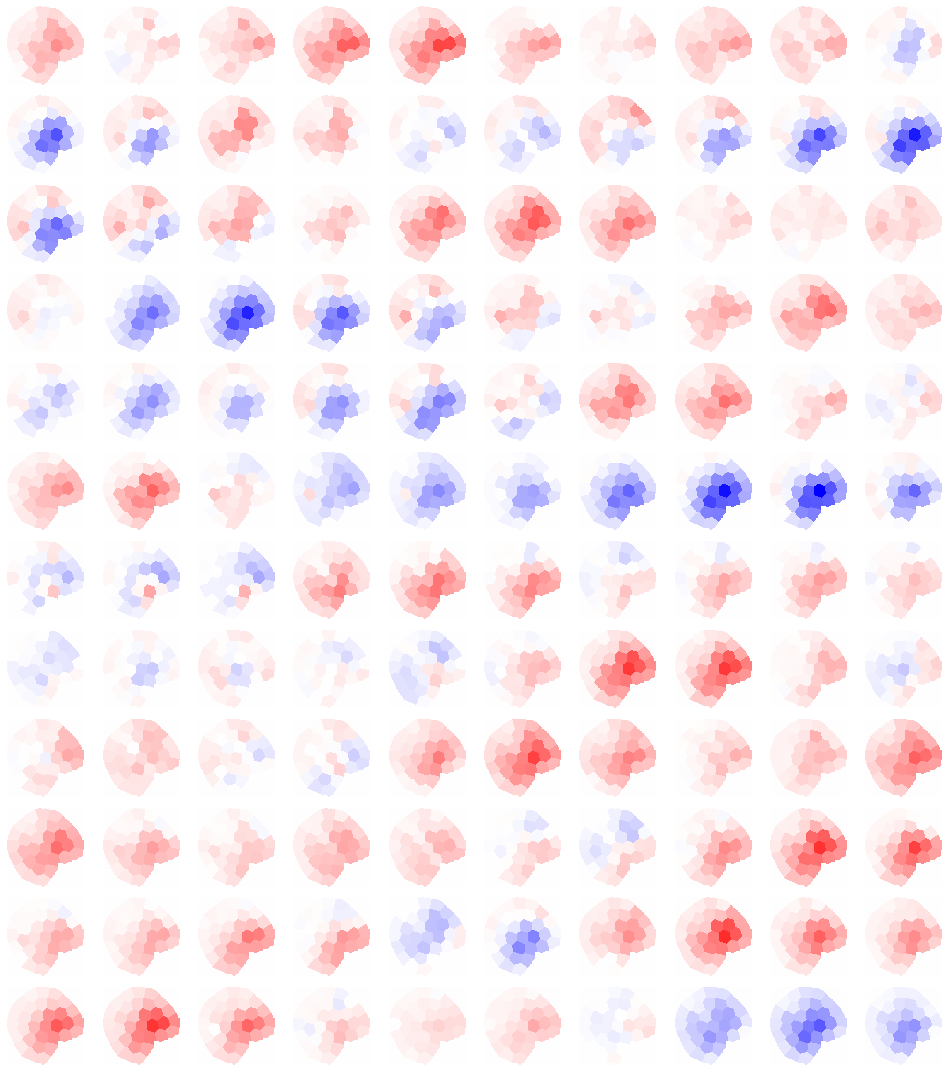

In [7]:
t = 1800
res = 1

_slice = x[..., t: t + res * 120]
vminmax = np.max(np.abs(_slice))

sns.set_style('white')
nrows, ncols = 12, 10
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 15))

for idx in range(_slice.shape[-1] // res):
    i, j = idx//ncols, idx%ncols
    axes[i, j].imshow(_slice[..., idx * res], vmin=-vminmax, vmax=vminmax, cmap='bwr', interpolation='none')
    axes[i, j].axis('off')
    
fig.tight_layout()
plt.show()

In [8]:
df = pd.DataFrame.from_dict(load['ca'])
node_labels = df.columns.values.tolist()
node_labels = {i: lbl for i, lbl in enumerate(node_labels)}

df.describe()

1            2            3            4            5   \
count  5500.000000  5500.000000  5500.000000  5500.000000  5500.000000   
mean      9.950022     7.462886    15.833222    18.590000     6.890506   
std      34.971738    17.472888    48.364873    75.839285    16.309902   
min    -121.533917   -65.914162  -157.338339  -228.680129   -57.130879   
25%     -12.150338    -2.618089   -15.504198   -31.219241    -2.494691   
50%      14.061867     9.701645    17.227419    19.850868     8.347605   
75%      34.164715    19.102119    48.675685    69.937909    17.498494   
max     113.395097    64.084574   197.450134   272.035867    64.523414   

                6            7            8            9            10  ...  \
count  5500.000000  5500.000000  5500.000000  5500.000000  5500.000000  ...   
mean     14.871452    23.089401     9.960408    20.164720     7.922781  ...   
std      52.929003    95.961068    29.056453    87.001072    24.993173  ...   
min    -185.918991  -294.918533   -94.537496  -241.243361   -87.025236  ...   
25%     -16.122491   -39.029113    -6.935430   -35.605604    -7.808730  ...   
50%      21.069022    24.073629    13.306092    22.689378    10.792059  ...   
75%      51.430363    90.316777    29.173123    78.239704    25.027086  ...   
max     200.099116   337.249981   128.029536   330.079347    82.740355  ...   

                23           24           25           26           27  \
count  5500.000000  5500.000000  5500.000000  5500.000000  5500.000000   
mean     26.444655    10.212601    30.706034    27.245183    20.450926   
std     128.042984    39.164303   163.363307   149.761722    99.828641   
min    -392.095452  -123.694746  -506.823790  -462.900998  -262.984579   
25%     -53.077627   -15.331987   -71.650001   -60.965329   -47.497536   
50%      46.355260    12.070137    54.397850    54.127597    21.731290   
75%     116.776740    36.833185   145.873365   131.192156    88.084183   
max     410.806037   144.064786   627.430641   560.118914   426.541931   

                28           29           30           31           32  
count  5500.000000  5500.000000  5500.000000  5500.000000  5500.000000  
mean     11.210833    20.561128    20.050845    10.779478    12.708043  
std      42.728231   118.565167   110.471562    54.211126    55.969319  
min    -119.700331  -353.549712  -337.730653  -159.969503  -165.499337  
25%     -15.679149   -58.394164   -50.555031   -25.917597   -25.867062  
50%      12.278707    35.644385    40.057912    15.374491    20.090031  
75%      39.659769   106.789575    97.965491    50.112869    53.269290  
max     160.965737   359.452087   330.712906   163.811693   177.639798  

[8 rows x 32 columns]

In [9]:
thresholds = [0.82, 0.85, 0.88, 0.89, 0.9, 0.91]
corrs = get_corrs(df, thresholds=thresholds)

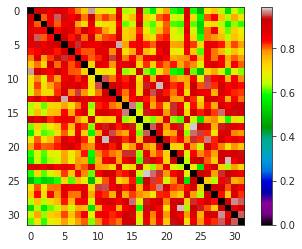

In [10]:
plt.imshow(corrs['pearson_corr'], cmap='nipy_spectral')
plt.colorbar()

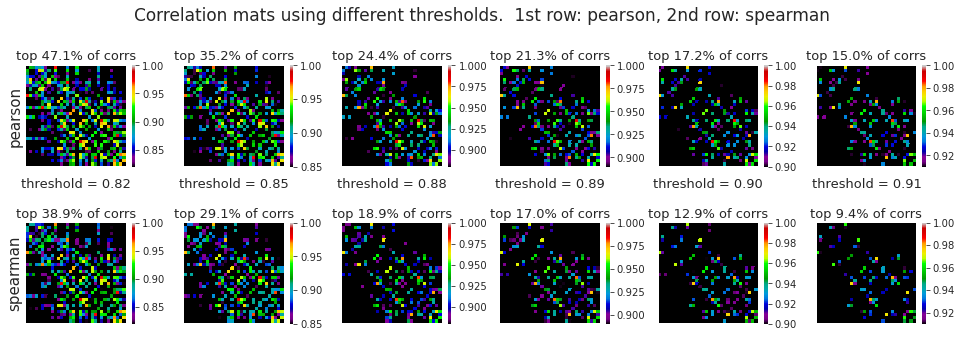

In [11]:
plot_corrs(corrs['pearson'], corrs['spearman'])

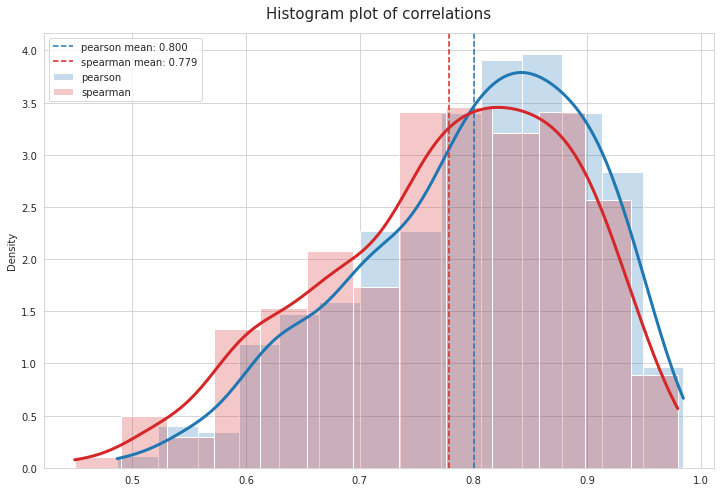

In [13]:
plot_corr_hist(
    corr_list=[corrs['pearson_corr'], corrs['spearman_corr']],
    labels=['pearson', 'spearman'],
    colors=['C0', 'C3'],
)

In [14]:
graphs = {th: nx.from_numpy_matrix(a) for th, a in corrs['spearman'].items()}

In [15]:
results_louvain = run_louvain(graphs[0.88], res=np.logspace(-1, 1, 1001))

  0%|          | 0/1001 [00:00<?, ?it/s]

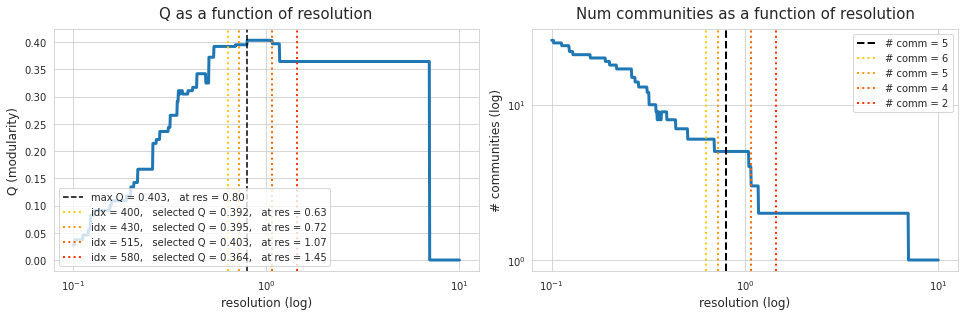

In [19]:
selected_idxs = [400, 430, 515, 580]
plot_louvain_results(results_louvain, selected_idxs=selected_idxs)

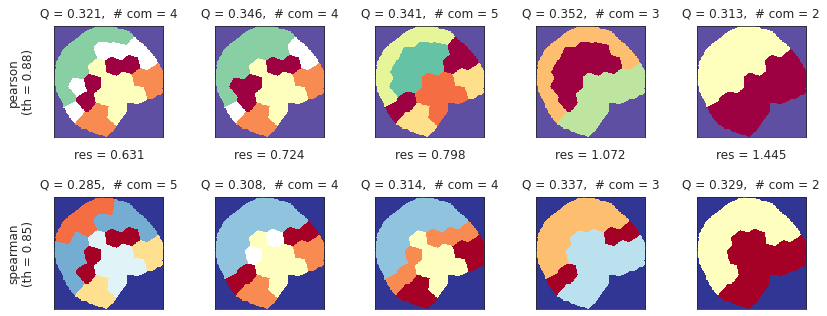

In [27]:
plot_louvain_communities(
    pearson=corrs['pearson'],
    spearman=corrs['spearman'],
    atlas=load['atlas_kmeans'],
    modularities=results_louvain['modularities'],
    selected_idxs=selected_idxs,
    pearson_th=0.88,
    spearman_th=0.85,
    figsize=(12, 4.5),
    colorbar=False, )

### Concanenate

In [29]:
data_all = {}
for run in [1, 3, 5, 7]:
    data_all[run] = load_organized_data(
        folder='atlas-32_unfiltered_unnormalized',#'filtered_low-0.001_high-4.000_ord-2_normalized',
        config=config,
        subject=6,
        session=1,
        run=run,
    )

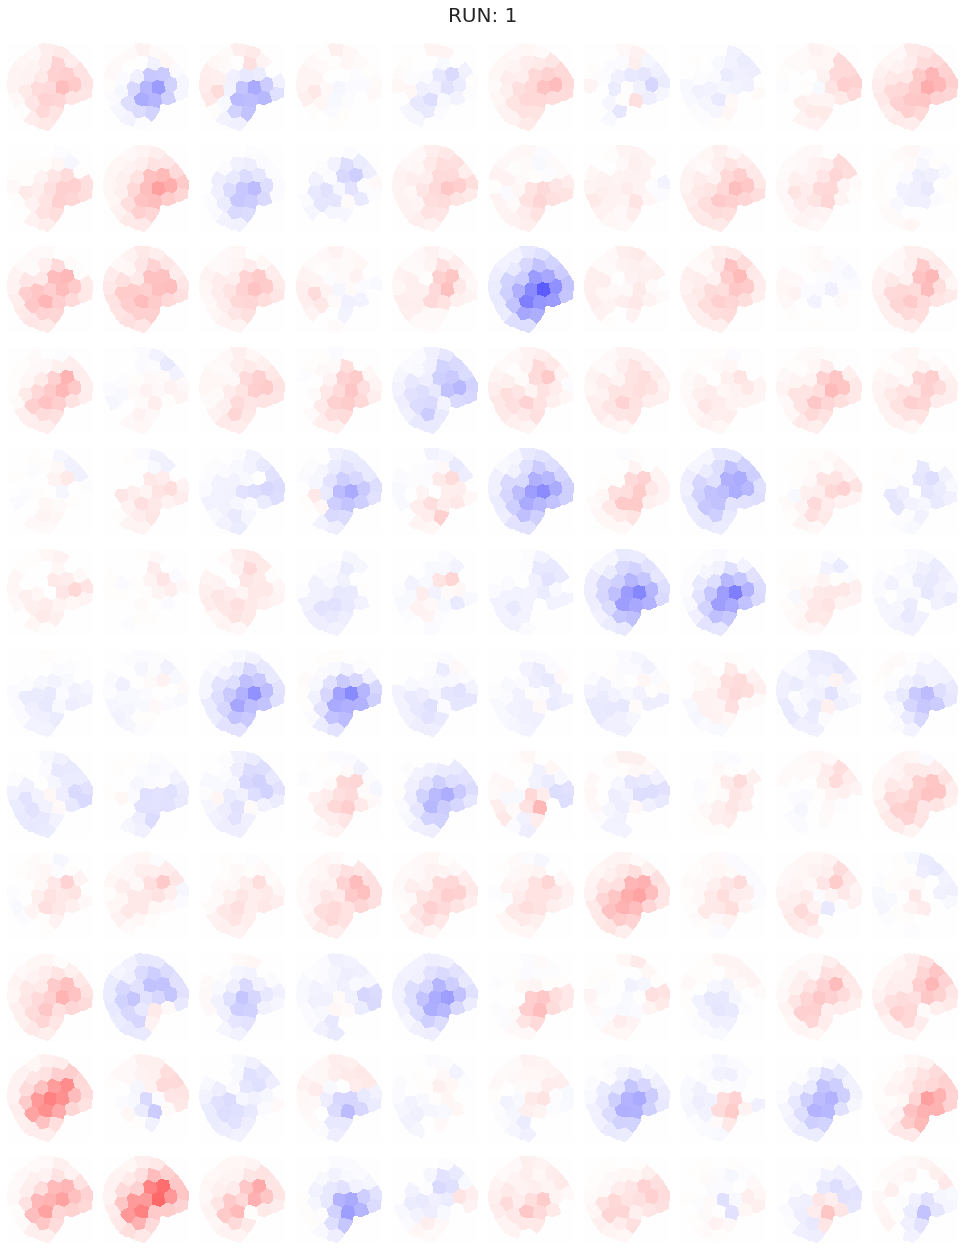

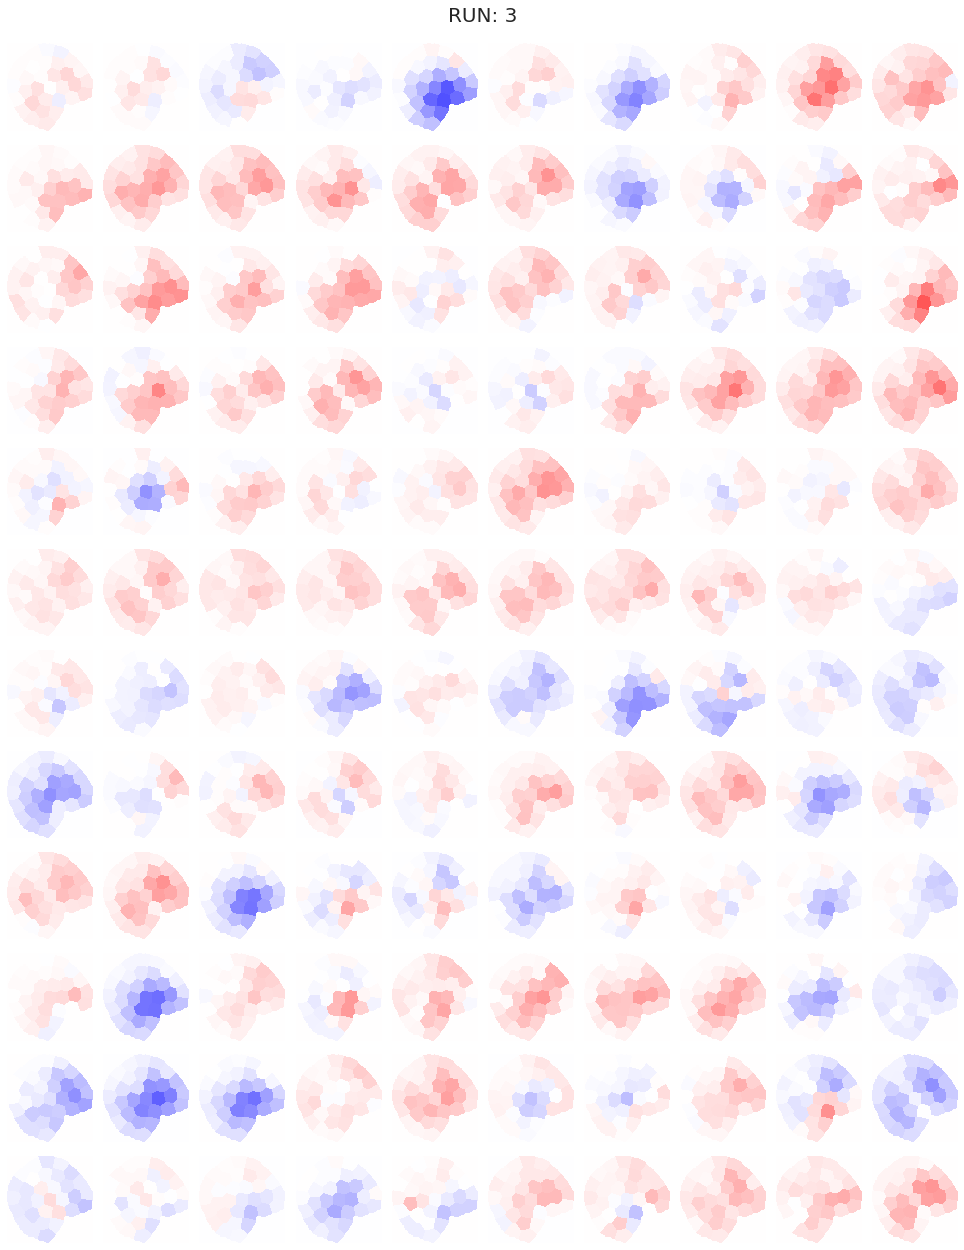

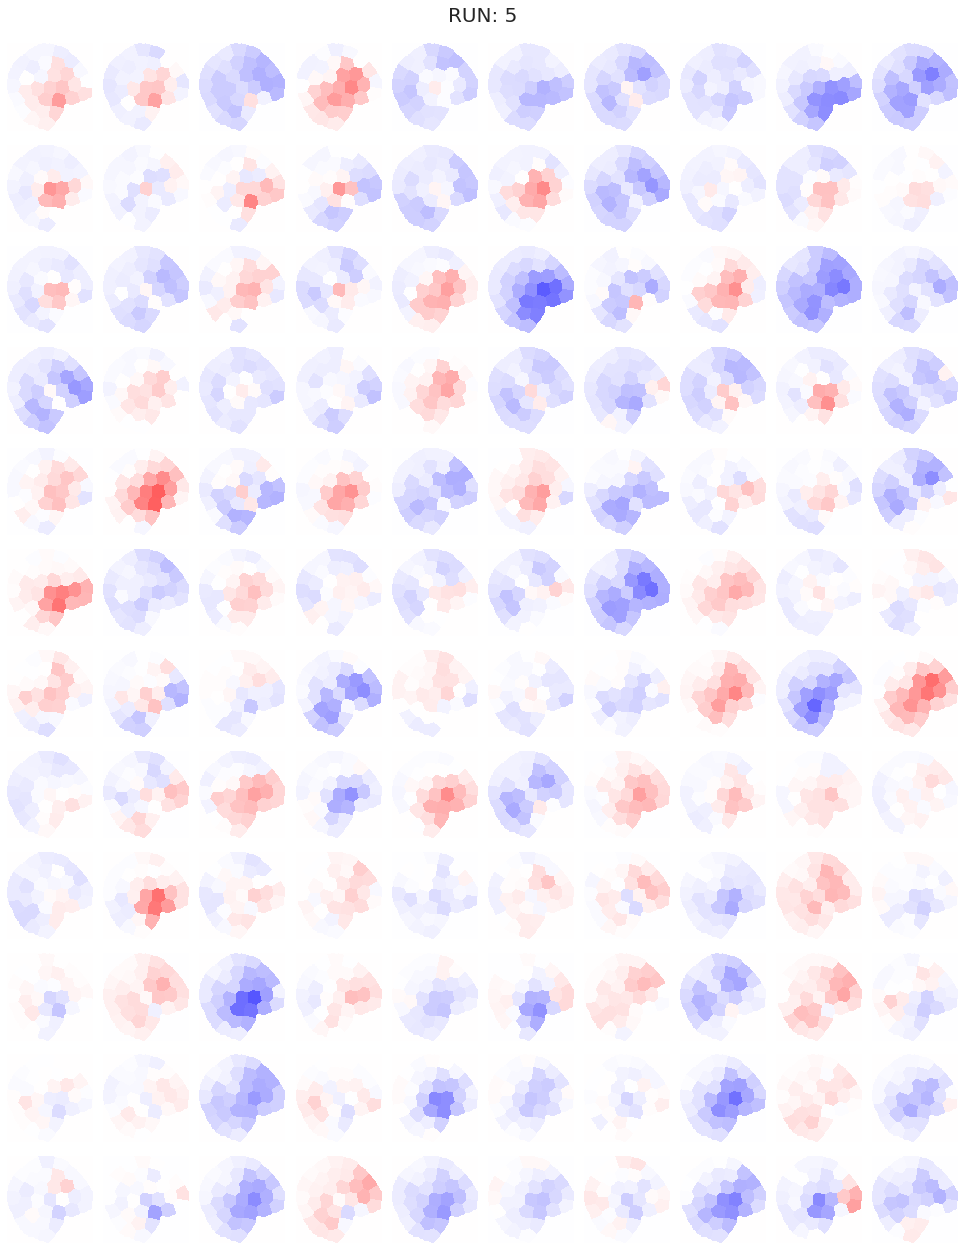

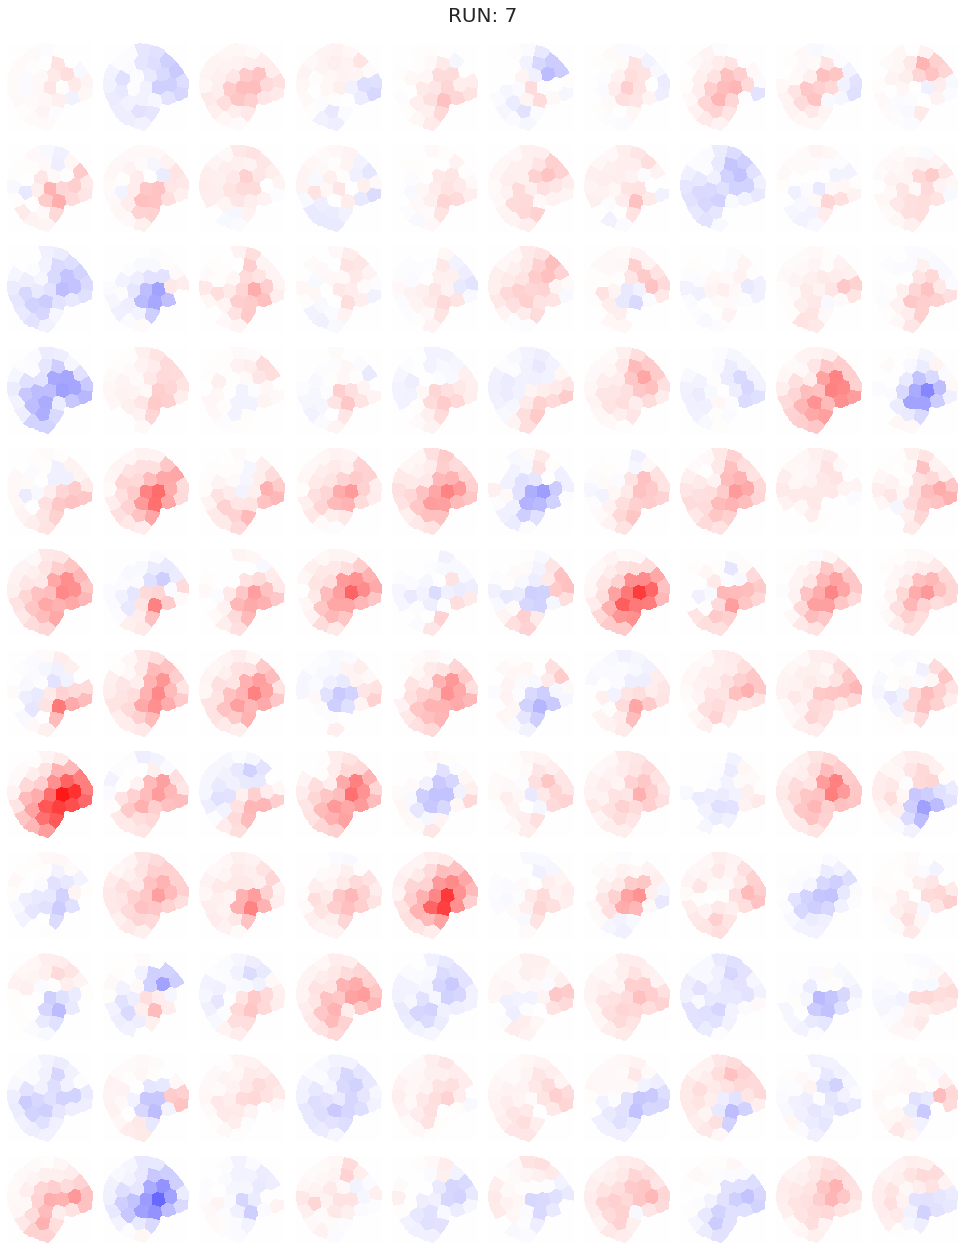

In [30]:
for run in [1, 3, 5, 7]:
    x = np.zeros(data_all[run]['atlas_kmeans'].shape + (list(data_all[run]['ca'].values())[0].shape[-1],))

    for key, time_series in data_all[run]['ca'].items():
        num_nan = np.isnan(time_series).sum()
        if num_nan > 0:
            print(key, num_nan)
            continue

        x[data_all[run]['atlas_kmeans'] == key] = data_all[run]['ca'][key]
    
    t = 1800
    res = 10

    _slice = x[..., t: t + res * 120]
    vminmax = np.max(np.abs(_slice))

    sns.set_style('white')
    nrows, ncols = 12, 10
    fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 17))

    for idx in range(_slice.shape[-1] // res):
        i, j = idx//ncols, idx%ncols
        axes[i, j].imshow(_slice[..., idx * res], vmin=-vminmax, vmax=vminmax, cmap='bwr', interpolation='none')
        axes[i, j].axis('off')

    fig.tight_layout()
    fig.suptitle('RUN: {:d}'.format(run), fontsize=20, y=1.02)
    plt.show()
    
    print('\n\n')

In [32]:
df = pd.DataFrame()

for run, load in data_all.items():
    _df = pd.DataFrame.from_dict(data_all[run]['ca'])
    print(run)
    print(_df.describe().loc[['mean','std']].mean(1))
    print('\n\n')
    df = pd.concat([df, _df])

node_labels = df.columns.values.tolist()
node_labels = {i: lbl for i, lbl in enumerate(node_labels)}

df.describe()

1
mean    18.904539
std     87.581752
dtype: float64



3
mean    -4.942912
std     60.641045
dtype: float64



5
mean     1.818379
std     75.395876
dtype: float64



7
mean     2.439728
std     59.234661
dtype: float64





1             2             3             4             5   \
count  22000.000000  22000.000000  22000.000000  22000.000000  22000.000000   
mean       2.459260      2.485588      3.455379      4.039046      2.374993   
std       29.899517     16.542431     40.063984     64.888386     15.565762   
min     -121.533917    -65.914162   -157.338339   -239.908174    -57.130879   
25%      -17.530416     -8.319232    -23.474224    -40.451340     -7.613625   
50%        2.427390      1.995129      1.803111      2.130959      2.047259   
75%       21.933320     12.550621     28.656811     45.508530     11.488059   
max      150.941351    109.697285    202.783210    367.812008    110.318514   

                 6             7             8             9             10  \
count  22000.000000  22000.000000  22000.000000  22000.000000  22000.000000   
mean       3.266676      5.237905      2.933955      4.789581      2.290660   
std       42.407406     76.884425     25.118512     74.319491     22.494364   
min     -185.918991   -294.918533    -94.537496   -249.067344    -87.025236   
25%      -23.652208    -45.951119    -13.089147    -46.263670    -12.702324   
50%        1.763599      1.895229      1.808134      1.442798      2.345283   
75%       28.963197     53.049379     17.477235     51.864440     17.008745   
max      304.656728    449.297591    245.471202    468.156378    117.181262   

       ...            23            24            25            26  \
count  ...  22000.000000  22000.000000  22000.000000  22000.000000   
mean   ...      5.786804      2.313835      8.094811      8.298571   
std    ...    105.095812     34.603482    134.379030    135.885182   
min    ...   -392.095452   -123.694746   -506.823790   -498.050685   
25%    ...    -53.744787    -20.986542    -73.094842    -75.489592   
50%    ...      8.059117      1.556268     10.768465     11.786504   
75%    ...     69.973773     24.773099     93.206050     91.813576   
max    ...    860.730769    171.122094    855.324137   1270.538706   

                 27            28            29            30            31  \
count  22000.000000  22000.000000  22000.000000  22000.000000  22000.000000   
mean       4.516968      2.475440      3.294907      3.991553      1.836407   
std       80.165377     37.052926     93.428001     92.807410     44.227134   
min     -263.311264   -129.304197   -353.549712   -337.730653   -160.408042   
25%      -48.821854    -22.671406    -52.937600    -48.633956    -27.430289   
50%        1.380492      1.211863      4.365510      6.677868      1.081107   
75%       53.408729     25.961589     62.529394     60.986495     30.141878   
max      502.187452    170.218454    590.073551    747.977547    259.343871   

                 32  
count  22000.000000  
mean       1.868005  
std       46.887557  
min     -165.499337  
25%      -28.456976  
50%        1.185101  
75%       31.201560  
max      323.654188  

[8 rows x 32 columns]

In [36]:
thresholds = [0.84, 0.85, 0.86, 0.87, 0.88, 0.9]
corrs = get_corrs(df, thresholds=thresholds)

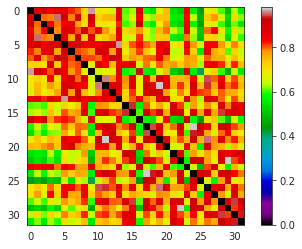

In [37]:
plt.imshow(corrs['pearson_corr'], cmap='nipy_spectral')
plt.colorbar()

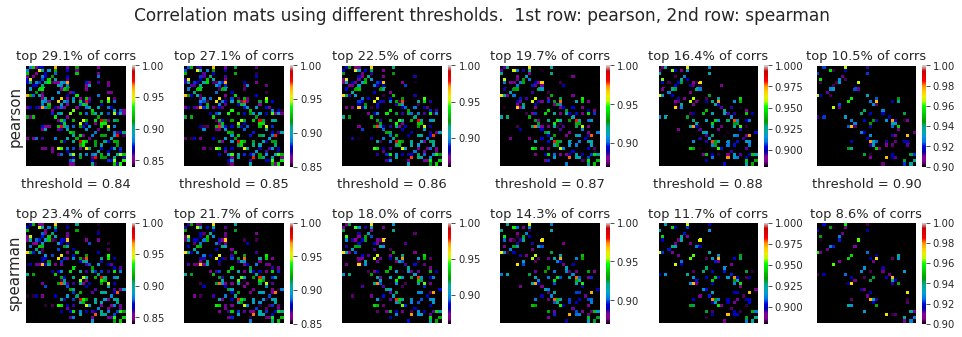

In [38]:
plot_corrs(corrs['pearson'], corrs['spearman'])

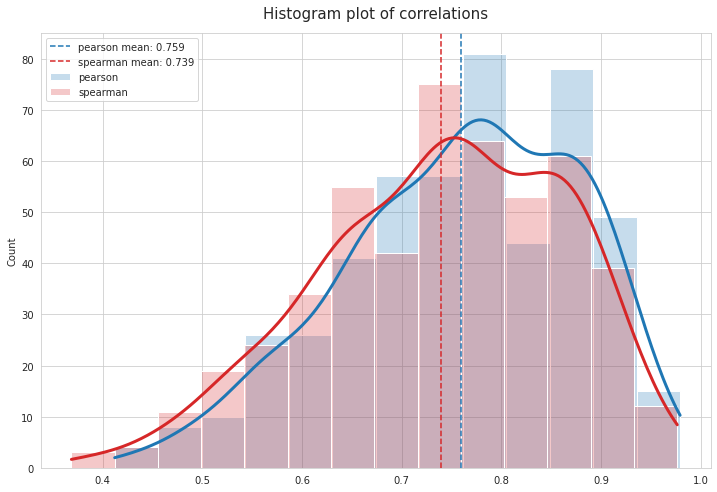

In [39]:
plot_corr_hist(
    corr_list=[corrs['pearson_corr'], corrs['spearman_corr']],
    labels=['pearson', 'spearman'],
    colors=['C0', 'C3'],
)

In [40]:
graphs = {th: nx.from_numpy_matrix(a) for th, a in corrs['spearman'].items()}

In [41]:
results_louvain = run_louvain(graphs[0.88], res=np.logspace(-1, 1, 1001))

  0%|          | 0/1001 [00:00<?, ?it/s]

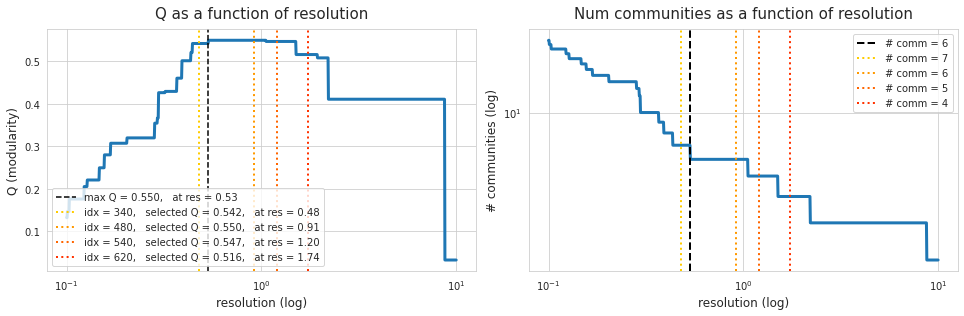

In [49]:
selected_idxs = [340, 480, 540, 620]
plot_louvain_results(results_louvain, selected_idxs=selected_idxs)

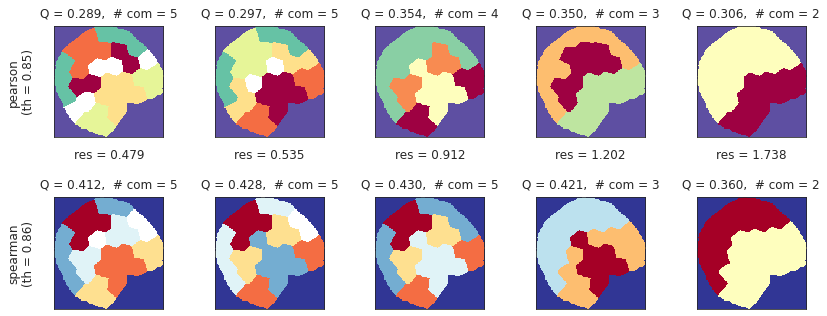

In [60]:
plot_louvain_communities(
    pearson=corrs['pearson'],
    spearman=corrs['spearman'],
    atlas=load['atlas_kmeans'],
    modularities=results_louvain['modularities'],
    selected_idxs=selected_idxs,
    pearson_th=0.85,
    spearman_th=0.86,
    figsize=(12, 4.5),
    colorbar=False, )

### Finer scale

In [28]:
data_all = {}
for run in [1, 3, 5, 7]:
    data_all[run] = load_organized_data(
        folder='atlas-2048_unfiltered_unnormalized',#'filtered_low-0.001_high-4.000_ord-2_normalized',
        config=config,
        subject=6,
        session=1,
        run=run,
    )

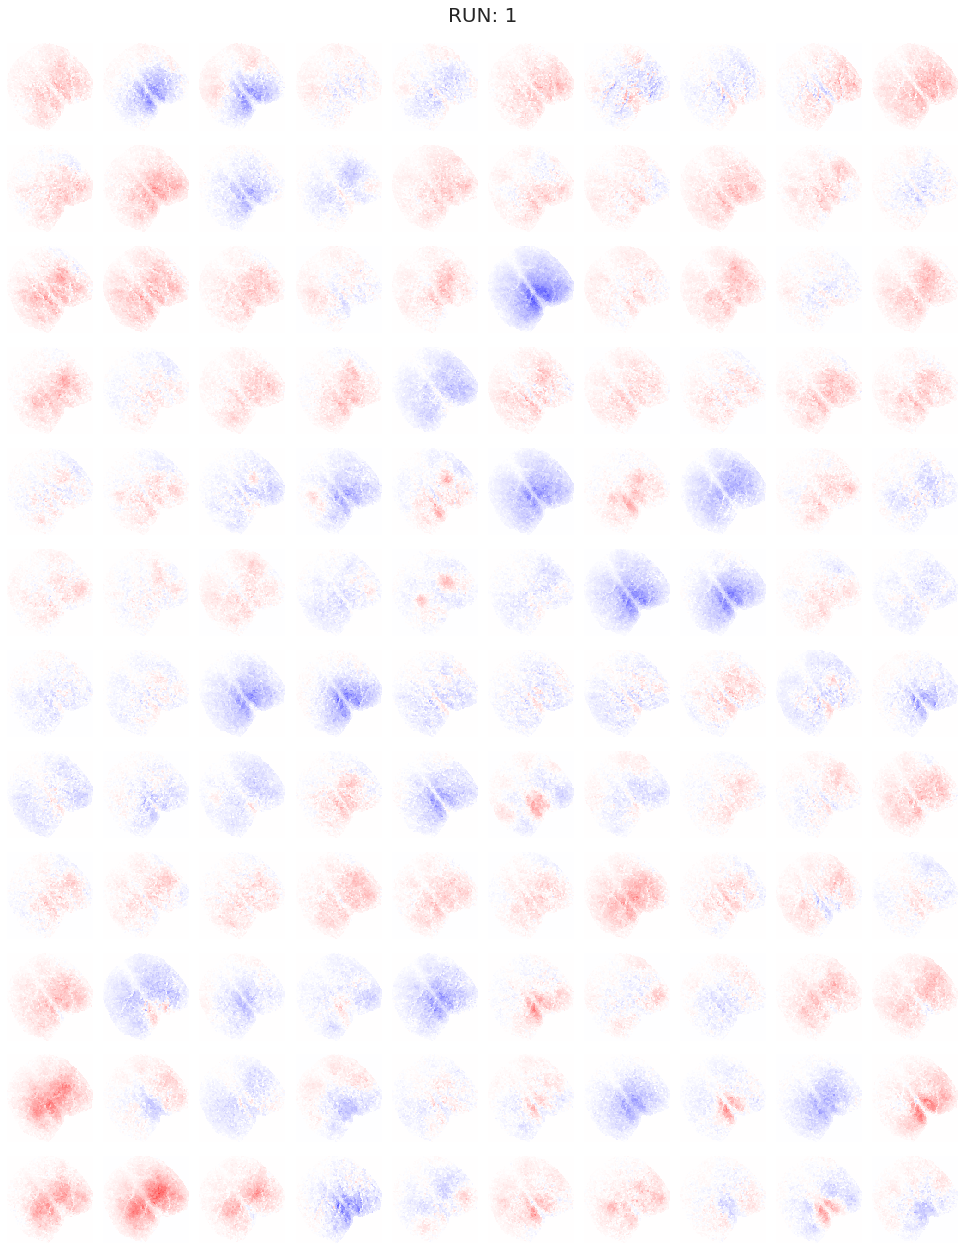

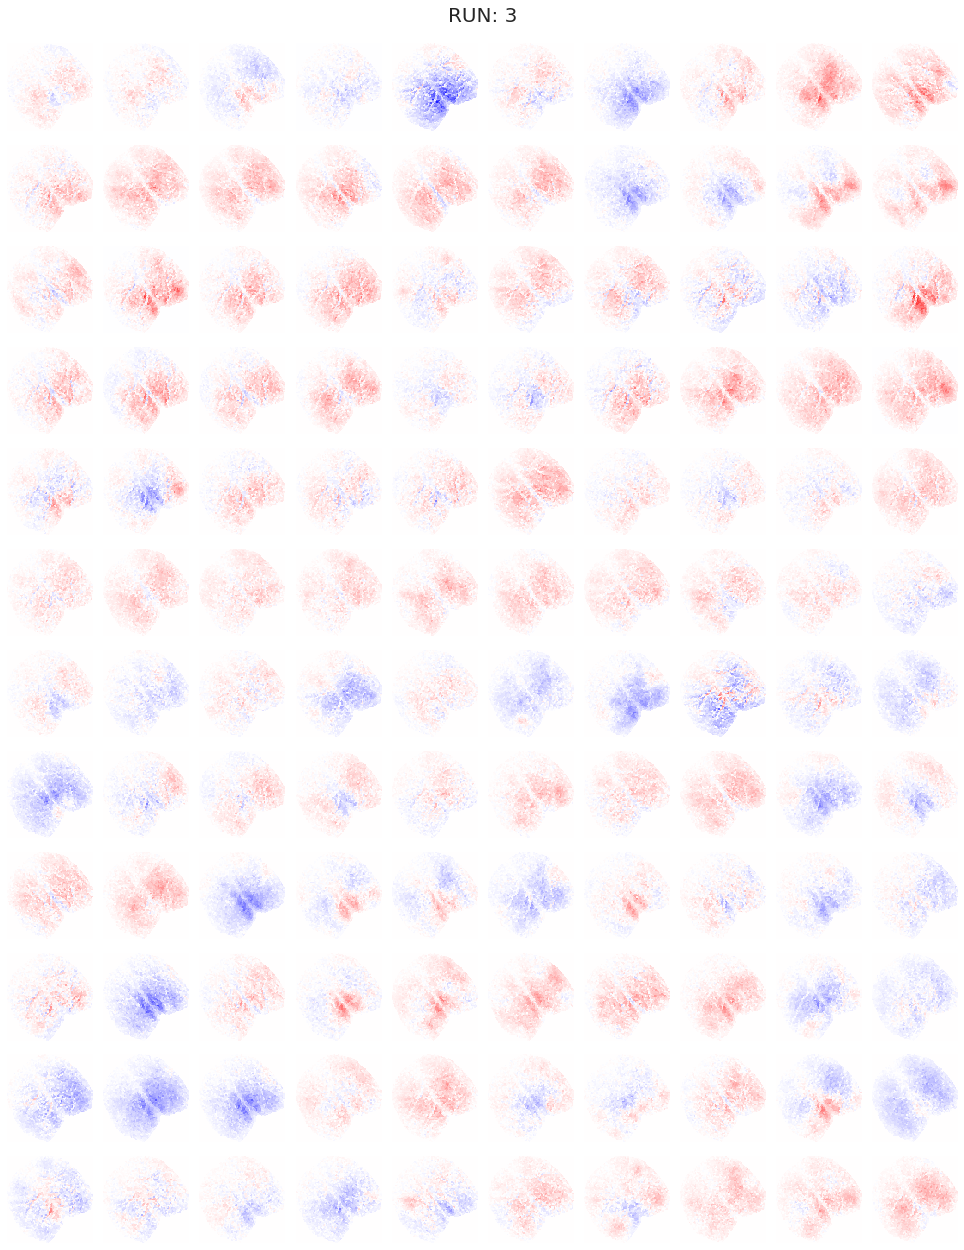

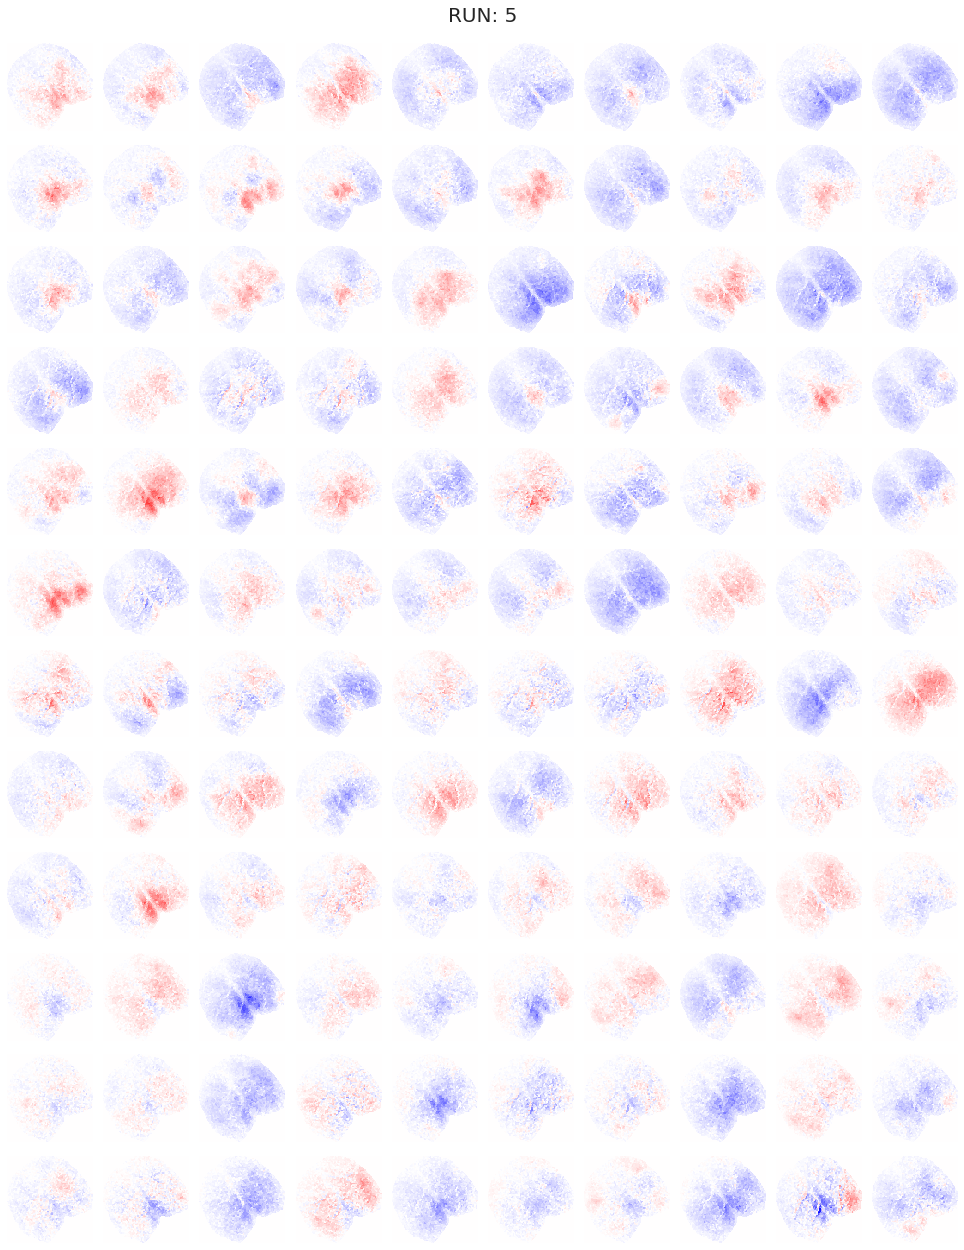

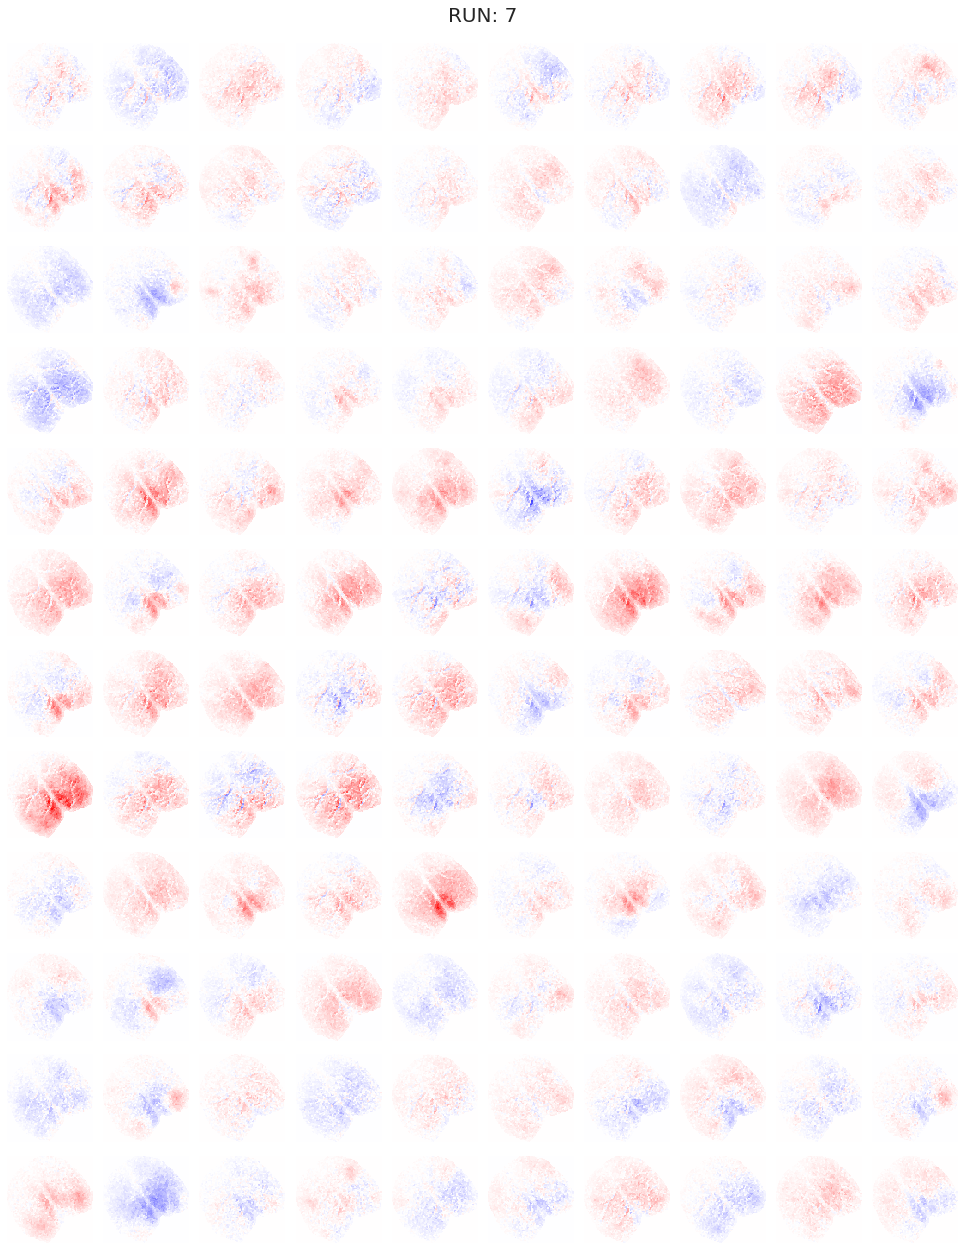

In [29]:
for run in [1, 3, 5, 7]:
    x = np.zeros(data_all[run]['atlas_kmeans'].shape + (list(data_all[run]['ca'].values())[0].shape[-1],))

    for key, time_series in data_all[run]['ca'].items():
        num_nan = np.isnan(time_series).sum()
        if num_nan > 0:
            print(key, num_nan)
            continue

        x[data_all[run]['atlas_kmeans'] == key] = data_all[run]['ca'][key]
    
    t = 1800
    res = 10

    _slice = x[..., t: t + res * 120]
    vminmax = np.max(np.abs(_slice))

    sns.set_style('white')
    nrows, ncols = 12, 10
    fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 17))

    for idx in range(_slice.shape[-1] // res):
        i, j = idx//ncols, idx%ncols
        axes[i, j].imshow(_slice[..., idx * res], vmin=-vminmax, vmax=vminmax, cmap='bwr', interpolation='none')
        axes[i, j].axis('off')

    fig.tight_layout()
    fig.suptitle('RUN: {:d}'.format(run), fontsize=20, y=1.02)
    plt.show()
    
    print('\n\n')

In [31]:
df = pd.DataFrame()

for run, load in data_all.items():
    _df = pd.DataFrame.from_dict(data_all[run]['ca'])
    print(run)
    print(_df.describe().loc[['mean','std']].mean(1))
    print('\n\n')
    df = pd.concat([df, _df])

node_labels = df.columns.values.tolist()
node_labels = {i: lbl for i, lbl in enumerate(node_labels)}

df.describe()

1
mean    18.729764
std     94.845306
dtype: float64



3
mean    -4.891482
std     69.669818
dtype: float64



5
mean     1.756480
std     83.384296
dtype: float64



7
mean     2.402372
std     67.622433
dtype: float64





1             2             3             4             5     \
count  22000.000000  22000.000000  22000.000000  22000.000000  22000.000000   
mean       2.539600      2.492350      2.402239      2.454531      2.459049   
std       21.071502     21.204419     21.854102     23.874212     22.498945   
min      -81.164087    -77.025150    -81.385529    -80.835804    -79.285951   
25%      -11.604598    -11.684879    -12.269345    -13.818012    -12.727596   
50%        2.135894      2.310709      2.156601      1.852993      2.287265   
75%       16.161393     16.123364     16.597939     17.762278     17.255288   
max      103.121706     94.835361     93.820520    114.802198    120.430579   

               6             7             8             9             10    \
count  22000.000000  22000.000000  22000.000000  22000.000000  22000.000000   
mean       2.404069      2.464216      2.498584      2.448209      2.661953   
std       20.225628     21.738131     24.914106     24.296303     24.568039   
min      -69.821959    -72.667626    -91.017195    -93.195370    -93.439453   
25%      -11.154096    -12.128446    -14.345256    -13.916741    -13.730839   
50%        1.914692      2.131674      2.090989      2.212126      2.065520   
75%       15.379847     16.452061     18.522957     18.290226     18.506764   
max       92.793580    105.466415    117.265454    116.200744    111.067106   

       ...          2039          2040          2041          2042  \
count  ...  22000.000000  22000.000000  22000.000000  22000.000000   
mean   ...      2.486342      2.648399      2.226385      3.090426   
std    ...     35.609023     35.577926     35.091944     30.230269   
min    ...   -140.849974   -129.244875   -153.813993   -102.539254   
25%    ...    -21.251384    -21.031502    -21.487150    -16.989568   
50%    ...      1.208709      0.643312      1.008846      2.009102   
75%    ...     24.823580     24.342867     24.836976     22.336606   
max    ...    212.469960    200.734613    213.529444    181.323752   

               2043          2044          2045          2046          2047  \
count  22000.000000  22000.000000  22000.000000  22000.000000  22000.000000   
mean       3.118287      3.467110      2.769338      3.547502      3.450560   
std       31.308877     32.673118     29.448787     27.927970     27.071712   
min     -112.790723   -113.327305   -119.016298   -104.273515    -91.550085   
25%      -17.887082    -18.712641    -16.996166    -15.117875    -14.789124   
50%        1.852542      1.593085      1.495724      2.515808      1.911372   
75%       22.875130     23.848172     21.132989     21.277934     20.259388   
max      179.041833    169.631887    222.316534    165.333862    187.587778   

               2048  
count  22000.000000  
mean       3.686031  
std       27.213138  
min      -87.709121  
25%      -14.466057  
50%        2.174827  
75%       20.343965  
max      169.166023  

[8 rows x 2048 columns]

In [32]:
thresholds = [0.6, 0.7, 0.75, 0.8, 0.85]
corrs = get_corrs(df, thresholds=thresholds)

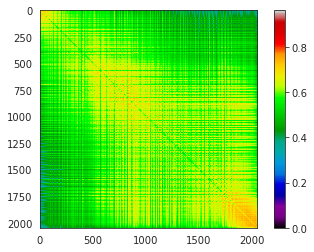

In [33]:
plt.imshow(corrs['pearson_corr'], cmap='nipy_spectral')
plt.colorbar()

In [91]:
from importlib import reload
from utils import plotting
reload(plotting)

from utils.plotting import *

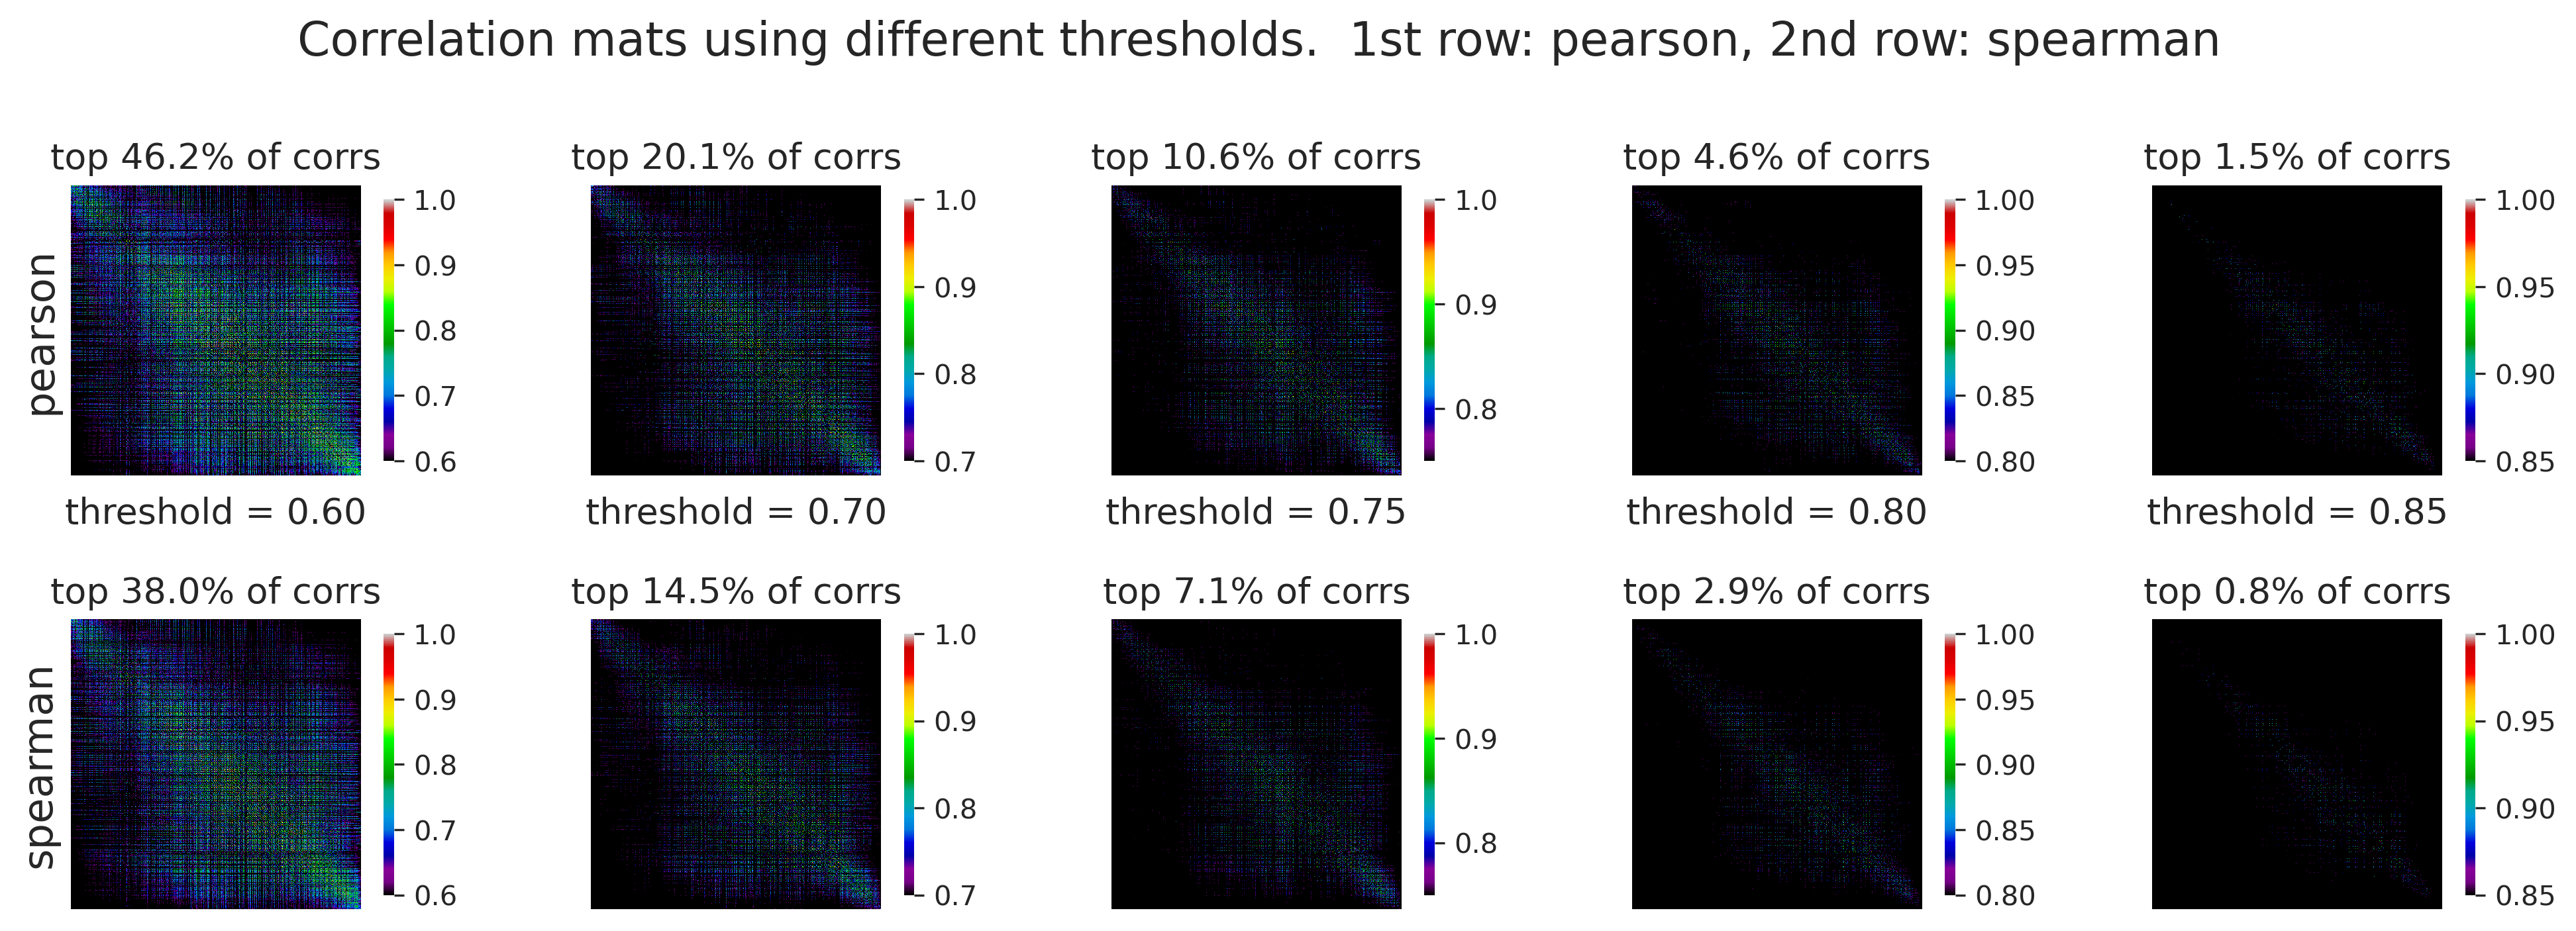

In [92]:
fig, axes = plot_corrs(corrs['pearson'], corrs['spearman'], dpi=300)

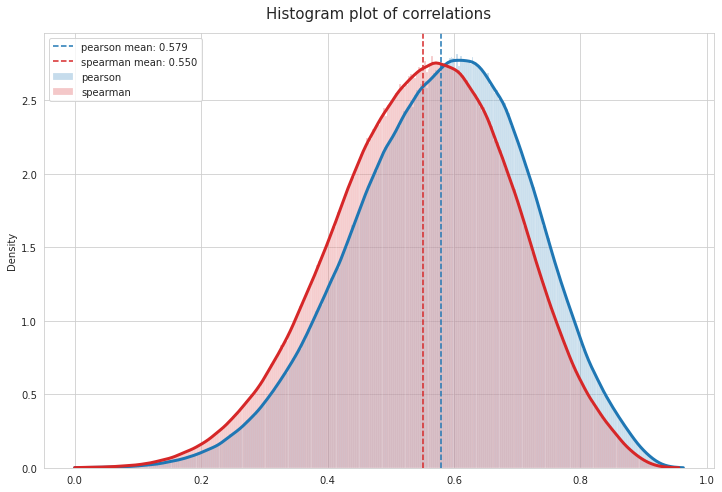

In [93]:
plot_corr_hist(
    corr_list=[corrs['pearson_corr'], corrs['spearman_corr']],
    labels=['pearson', 'spearman'],
    colors=['C0', 'C3'],
)

In [94]:
graphs = {th: nx.from_numpy_matrix(a) for th, a in corrs['spearman'].items()}

In [95]:
results_louvain = run_louvain(graphs[0.7], res=np.logspace(-1, 1, 1001))

  0%|          | 0/1001 [00:00<?, ?it/s]

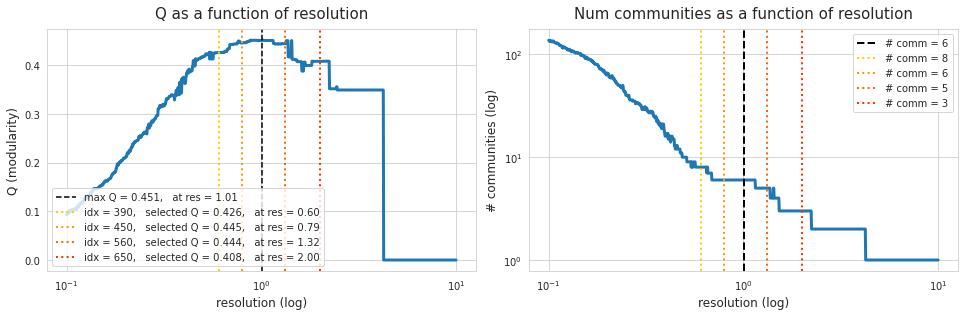

In [115]:
selected_idxs = [390, 450, 560, 650]
plot_louvain_results(results_louvain, selected_idxs=selected_idxs)

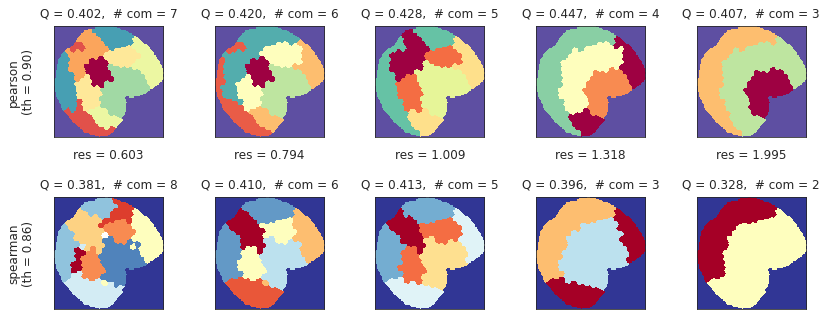

In [127]:
plot_louvain_communities(
    pearson=corrs['pearson'],
    spearman=corrs['spearman'],
    atlas=load['atlas_kmeans'],
    modularities=results_louvain['modularities'],
    selected_idxs=selected_idxs,
    pearson_th=0.90,
    spearman_th=0.86,
    figsize=(12, 4.5),
    colorbar=False, )

### Network measures

In [118]:
field_names = ('subject', 'session', 'run', 'threshold', 'node_labels', 'adjacency', 'graph', 'cfg')

Data = collections.namedtuple(
    typename='Data',
    field_names=field_names,
)

In [119]:
config = Config()
thresholds = [0.70, 0.75, 0.80, 0.85, 0.90]

data_all = {}
for subject in tqdm(range(1, config.num_subjects + 1)):
    for session in tqdm(range(1, config.num_sessions + 1), leave=False):
        for run in range(1, config.num_runs + 1):

            load = load_organized_data(
                folder='unfiltered_normalized',
                config=config,
                subject=subject,
                session=session,
                run=run,
            )
            
            if load is None:
                continue
            
            df = pd.DataFrame.from_dict(load['ca'])
            node_labels = df.columns.values.tolist()
            node_labels = {i: lbl for i, lbl in enumerate(node_labels)}
            corrs = get_corrs(df, thresholds=thresholds)

            key = 'sub-SLC{:02d}'.format(subject)
            key += '_ses-{:d}'.format(session)
            key += '_run-{:d}'.format(run)
            
            for th in thresholds:
                a = corrs['spearman'][th]
                g = nx.from_numpy_matrix(a)
                
                data_all['{:s}_th-{:.2f}'.format(key, th)] = Data(
                    subject=subject,
                    session=session,
                    run=run,
                    threshold=th,
                    node_labels=node_labels,
                    adjacency=a,
                    graph=g,
                    cfg=mk_config_model(g, weighted=True),
                )

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Warning! File not found, moving on . . .
['sub-SLC03', 'ses-1', 'run-1', 'organized', 'ca']



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Warning! File not found, moving on . . .
['sub-SLC05', 'ses-1', 'run-5', 'organized', 'ca']



  0%|          | 0/3 [00:00<?, ?it/s]

Warning! File not found, moving on . . .
['sub-SLC06', 'ses-3', 'run-2', 'organized', 'ca']



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Warning! File not found, moving on . . .
['sub-SLC08', 'ses-1', 'run-7', 'organized', 'ca']



  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Warning! File not found, moving on . . .
['sub-SLC10', 'ses-3', 'run-1', 'organized', 'ca']



In [120]:
# network measures
from networkx.algorithms.cluster import transitivity, average_clustering
from networkx.algorithms.assortativity import degree_pearson_correlation_coefficient
from networkx.algorithms.efficiency_measures import global_efficiency, local_efficiency
from networkx.algorithms.approximation.clique import large_clique_size
from networkx.algorithms.shortest_paths.generic import average_shortest_path_length

In [162]:
measures_df = pd.DataFrame()

dict_list = []
for k, data in tqdm(data_all.items()):
    # nodes, degrees = list(zip(*g.degree()))
    
    num_nodes = len(data.node_labels)
    
    # the real graph
    _avg_clustering = average_clustering(data.graph, weight='weight')
    _local_efficiency = local_efficiency(data.graph)
    _large_clique_ratio = large_clique_size(data.graph) / num_nodes
    try:
        _avg_shortest_path_len = average_shortest_path_length(data.graph, weight='weight')
    except:
        _avg_shortest_path_len = np.nan
    _global_efficiency = global_efficiency(data.graph)
    _degree_corr_coef = degree_pearson_correlation_coefficient(data.graph, weight='weight')

    data_dict = {
        'tag': ['real'] * 6,
        'subject': [data.subject] * 6,
        'session': [data.session] * 6,
        'run': [data.run] * 6,
        'threshold': [data.threshold] * 6,
        'num_regions': [num_nodes] * 6,
        'lbl': [
            'avg_clustering',
            'local_efficiency',
            'large_clique_ratio',
            'avg_shortest_path_len',
            'global_efficiency',
            'degree_corr_coef',  # assortativity
        ],
        'val': [
            _avg_clustering,
            _local_efficiency,
            _large_clique_ratio,
            _avg_shortest_path_len,
            _global_efficiency,
            _degree_corr_coef,
        ],
    }
    dict_list.append(data_dict)
    

    # configuration model
    _avg_clustering = average_clustering(data.cfg, weight='weight')
    _local_efficiency = local_efficiency(data.cfg)
    _large_clique_ratio = large_clique_size(data.cfg) / num_nodes
    try:
        _avg_shortest_path_len = average_shortest_path_length(data.cfg, weight='weight')
    except:
        _avg_shortest_path_len = np.nan
    _global_efficiency = global_efficiency(data.cfg)
    _degree_corr_coef = degree_pearson_correlation_coefficient(data.cfg, weight='weight')

    data_dict = {
        'tag': ['cfg'] * 6,
        'subject': [data.subject] * 6,
        'session': [data.session] * 6,
        'run': [data.run] * 6,
        'threshold': [data.threshold] * 6,
        'num_regions': [num_nodes] * 6,
        'lbl': [
            'avg_clustering',
            'local_efficiency',
            'large_clique_ratio',
            'avg_shortest_path_len',
            'global_efficiency',
            'degree_corr_coef',  # assortativity
        ],
        'val': [
            _avg_clustering,
            _local_efficiency,
            _large_clique_ratio,
            _avg_shortest_path_len,
            _global_efficiency,
            _degree_corr_coef,
        ],
    }
    dict_list.append(data_dict)

measures_df = pd.DataFrame.from_dict(merge_dicts(dict_list))

  0%|          | 0/1025 [00:00<?, ?it/s]

...merging dicts: 0it [00:00, ?it/s]

In [163]:
measures_df

tag  subject  session  run  threshold  num_regions  \
0      real        1        1    1        0.7           66   
1      real        1        1    1        0.7           66   
2      real        1        1    1        0.7           66   
3      real        1        1    1        0.7           66   
4      real        1        1    1        0.7           66   
...     ...      ...      ...  ...        ...          ...   
12295   cfg       10        3    7        0.9           62   
12296   cfg       10        3    7        0.9           62   
12297   cfg       10        3    7        0.9           62   
12298   cfg       10        3    7        0.9           62   
12299   cfg       10        3    7        0.9           62   

                         lbl       val  
0             avg_clustering  0.609992  
1           local_efficiency  0.839339  
2         large_clique_ratio  0.378788  
3      avg_shortest_path_len       NaN  
4          global_efficiency  0.699184  
...                      ...       ...  
12295       local_efficiency  0.066340  
12296     large_clique_ratio  0.048387  
12297  avg_shortest_path_len       NaN  
12298      global_efficiency  0.207673  
12299       degree_corr_coef  0.011740  

[12300 rows x 8 columns]

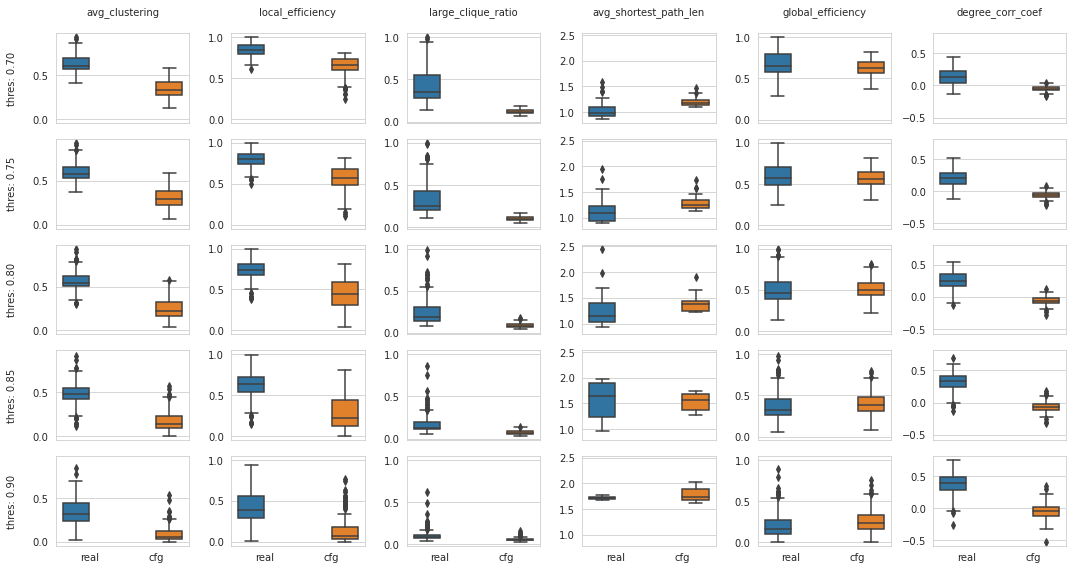

In [164]:
_ths = measures_df.threshold.unique().tolist()
_lbls = measures_df.lbl.unique().tolist()

sns.set_style('whitegrid')
fig, axes = plt.subplots(nrows=len(_ths), ncols=len(_lbls), figsize=(15, 8), sharey='col', sharex='all')

for i, th in enumerate(_ths):
    for j, lbl in enumerate(_lbls):
        selected_df = measures_df.loc[(measures_df.threshold == th) & (measures_df.lbl == lbl)]
        sns.boxplot(data=selected_df, y='val', x='tag', hue='tag', ax=axes[i, j])
        axes[i, j].legend().set_visible(False)
        axes[i, j].set_xlabel('')
        
        if i == 0:
            axes[i, j].set_title('{:s}\n'.format(lbl), fontsize=10)
            
        if j == 0:
            axes[i, j].set_ylabel('thres: {:.2f}\n'.format(th), fontsize=10)
        else:
            axes[i, j].set_ylabel('')

fig.savefig('net_measures.pdf', dpi=200)
fig.tight_layout()
plt.show()

In [ ]:
# TODO: make this general

def plot_louvain_communities(
    graphs: list,
    # pearson: dict,
    # spearman: dict,
    atlas: np.ndarray,
    # modularities: dict,
    # selected_idxs: list,
    # pearson_th: float = 0.7,
    # spearman_th: float = 0.8,
    figsize=(12, 4.5),
    colorbar=False, ):

    # x0, y0 = tuple(zip(*modularities.items()))
    # best_idx = np.argmax(y0)
    # max_mod = y0[best_idx]
    
    sns.set_style('white')
    plot_idxs = sorted(selected_idxs + [best_idx])
    fig, axes = plt.subplots(2, len(plot_idxs), figsize=figsize)

    for ii, idx in enumerate(plot_idxs):
        # g = nx.from_numpy_matrix(spearman[spearman_th])
        coms = cdlib_algorithms.louvain(
            g_original=g,
            weight='weight',
            resolution=best_idx[idx],
            randomize=False,
        )
        partition = convert('community', 'partition', community=coms.communities)
        output = filter_islands(partition, atlas, node_labels, min_com_size=3)
        # comm_mat, comm_dict = filter_islands(partition, labels, scale=size, min_com_size=5)
        q = nx_comm.modularity(g, communities=coms.communities)

        im = axes[0, ii].imshow(output['comm_mat'], cmap='RdYlBu_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[0, ii], shrink=0.7)
        msg = 'res = {:.3f}\n\nQ = {:.3f},  # com = {:d}'
        msg = msg.format(x0[idx], q, len(np.unique(comm_mat[comm_mat>-1])))
        axes[0, ii].set_title(msg, y=1.03)

        g = nx.from_numpy_matrix(pearson[0.8])
        partition = community_louvain.best_partition(g, resolution=x0[idx], random_state=42)
        comm_mat, comm_dict = filter_islands(partition, labels, scale=size, min_com_size=5)
        q = nx_comm.modularity(g, communities=comm_dict.values())

        im = axes[1, ii].imshow(comm_mat, cmap='Spectral_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[1, ii], shrink=0.7)
        msg = 'Q = {:.3f},  # com = {:d}'
        msg = msg.format(q, len(np.unique(comm_mat[comm_mat>-1])))
        axes[1, ii].set_title(msg, y=1.03)

        if ii == 0:
            axes[0, ii].set_ylabel('spearman\n(th = {:.2f})\n'.format(spearman_th), fontsize=12)
            axes[1, ii].set_ylabel('pearson\n(th = {:.2f})\n'.format(pearson_th), fontsize=12)
            
        for j in range(2):
            axes[j, ii].set_xticks([])
            axes[j, ii].set_yticks([])

    fig.tight_layout()
    plt.show()

    return